In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import shutil
import re
from skimage.io import imread
from collections import defaultdict
from PIL import Image
import imagehash

import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics.pairwise import cosine_similarity
import torchvision.transforms as transforms
import torch

# Working with Images Lab
## Information retrieval, preprocessing, and feature extraction

In this lab, you'll work with images of felines (cats), which have been classified according to their taxonomy. Each subfolder contains images of a particular species. The dataset is located [here](https://www.kaggle.com/datasets/datahmifitb/felis-taxonomy-image-classification) but it's also provided to you in the `data/` folder.

### Problem 1. Some exploration (1 point)
How many types of cats are there? How many images do we have of each? What is a typical image size? Are there any outliers in size?

In [3]:
folder_path = ("data/african-wildcat")
cat_set = set()
cat_counts = defaultdict(int)
image_sizes = []

for filename in os.listdir(folder_path):
    if filename.endswith((".jpg", ".png", ".jpeg")):
        cat_type = filename.split("_")[0].lower()
        path = os.path.join(folder_path, filename)
        with Image.open(path) as img:
            image_sizes.append(img.size)
        cat_set.add(cat_type)
        cat_counts[cat_type] += 1
cat_set

{'af (1).jpg',
 'af (10).jpg',
 'af (11).jpg',
 'af (12).jpg',
 'af (13).jpg',
 'af (14).jpg',
 'af (15).jpg',
 'af (16).jpg',
 'af (17).jpg',
 'af (18).jpg',
 'af (19).jpg',
 'af (2).jpg',
 'af (20).jpg',
 'af (21).jpg',
 'af (22).jpg',
 'af (23).jpg',
 'af (24).jpg',
 'af (25).jpg',
 'af (26).jpg',
 'af (27).jpg',
 'af (28).jpg',
 'af (29).jpg',
 'af (3).jpg',
 'af (30).jpg',
 'af (31).jpg',
 'af (32).jpg',
 'af (33).jpg',
 'af (34).jpg',
 'af (35).jpg',
 'af (36).jpg',
 'af (37).jpg',
 'af (38).jpg',
 'af (39).jpg',
 'af (4).jpg',
 'af (40).jpg',
 'af (41).jpg',
 'af (42).jpg',
 'af (43).jpg',
 'af (44).jpg',
 'af (45).jpg',
 'af (46).jpg',
 'af (47).jpg',
 'af (48).jpg',
 'af (49).jpg',
 'af (5).jpg',
 'af (50).jpg',
 'af (51).jpg',
 'af (52).jpg',
 'af (53).jpg',
 'af (54).jpg',
 'af (55).jpg',
 'af (56).jpg',
 'af (57).jpg',
 'af (58).jpg',
 'af (59).jpg',
 'af (6).jpg',
 'af (60).jpg',
 'af (61).jpg',
 'af (62).jpg',
 'af (63).jpg',
 'af (64).jpg',
 'af (65).jpg',
 'af (66).jpg'

In [4]:
cat_counts

defaultdict(int,
            {'af (1).jpg': 1,
             'af (10).jpg': 1,
             'af (11).jpg': 1,
             'af (12).jpg': 1,
             'af (13).jpg': 1,
             'af (14).jpg': 1,
             'af (15).jpg': 1,
             'af (16).jpg': 1,
             'af (17).jpg': 1,
             'af (18).jpg': 1,
             'af (19).jpg': 1,
             'af (2).jpg': 1,
             'af (20).jpg': 1,
             'af (21).jpg': 1,
             'af (22).jpg': 1,
             'af (23).jpg': 1,
             'af (24).jpg': 1,
             'af (25).jpg': 1,
             'af (26).jpg': 1,
             'af (27).jpg': 1,
             'af (28).jpg': 1,
             'af (29).jpg': 1,
             'af (3).jpg': 1,
             'af (30).jpg': 1,
             'af (31).jpg': 1,
             'af (32).jpg': 1,
             'af (33).jpg': 1,
             'af (34).jpg': 1,
             'af (35).jpg': 1,
             'af (36).jpg': 1,
             'af (37).jpg': 1,
             'af (38).jpg

In [5]:
sizes_data = pd.DataFrame(image_sizes, columns=["width", "height"])
sizes_data.index = range(1, len(sizes_data) + 1)
sizes_data

,width,height
1,265,190
2,274,184
3,275,183
4,263,192
5,230,219
...,...,...
87,275,183
88,272,185
89,275,183
90,272,182


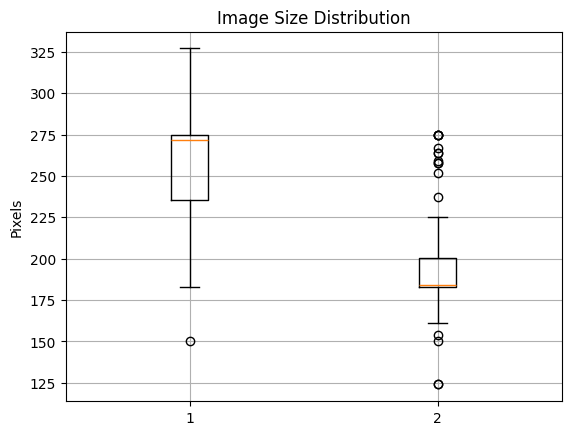

In [6]:
plt.boxplot([sizes_data["width"], sizes_data["height"]],label=["Width","Height"])
plt.title("Image Size Distribution")
plt.ylabel("Pixels")
plt.grid(True)
plt.show()

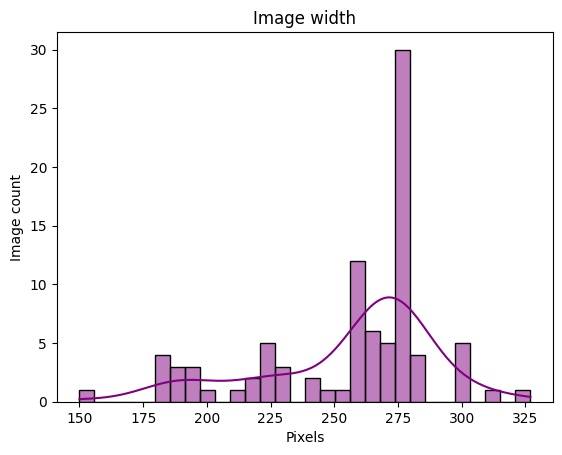

In [7]:
sns.histplot(sizes_data["width"], bins=30, kde=True,color="purple")
plt.title("Image width")
plt.xlabel("Pixels")
plt.ylabel("Image count")
plt.show()


### Problem 2. Duplicat(e)s (1 point)
Find a way to filter out (remove) identical images. I would recommnend using file hashes, but there are many approaches. Keep in mind that during file saving, recompression, etc., a lot of artifacts can change the file content (bytes), but not visually.

In [8]:
output_folder = "data/unique_african_wildcat"
os.makedirs(output_folder, exist_ok=True)
image_counter = 1

def extract_number(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else -1

sorted_filenames = sorted(os.listdir(folder_path), key=extract_number)

dhashes = []
phashes = []
whashes = []

similarity_threshold = 16

for filename in sorted_filenames:
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(folder_path, filename)
        try:
            img = Image.open(image_path).convert('RGB')
            
            dh = imagehash.dhash(img)
            ph = imagehash.phash(img)
            wh = imagehash.whash(img)
            
            is_duplicate = any(abs(dh - h) <= similarity_threshold for h in dhashes) or \
                        any(abs(ph - h) <= similarity_threshold for h in phashes) or \
                        any(abs(wh - h) <= similarity_threshold for h in whashes)
            
            if not is_duplicate:
                dhashes.append(dh)
                phashes.append(ph)
                whashes.append(wh)
                
                new_filename = f"af_{image_counter:02d}.jpg"
                destination_path = os.path.join(output_folder, new_filename)
                shutil.copy(image_path, destination_path)

                image_counter += 1
                
        except Exception as e:
            print(f"Error {filename}: {e}")
len(os.listdir(output_folder))

54

### Problem 3. Loading a model (2 points)
Find a suitable, trained convolutional neural network classifier. I recommend `ResNet50` as it's small enough to run well on any machine and powerful enough to make reasonable predictions. Most ready-made classifiers have been trained for 1000 classes.

You'll need to install libraries and possibly tinker with configurations for this task. When you're done, display the total number of layers and the total number of parameters. For ResNet50, you should expect around 50 layers and 25M parameters.

##### You load a pre-trained version of the **ResNet50** model. I'm counting **"Conv2d"** and **"Linear"** because they are the main parameter layers.

In [9]:
resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)
resnet50.eval()

total_params = sum(p.numel() for p in resnet50.parameters())
key_layers = (nn.Conv2d, nn.Linear)
true_layers = [m for m in resnet50.modules() if isinstance(m, key_layers)]
print(f"Number of base layers: {len(true_layers)}")
print(f"Total number of parameters: {total_params:,}")

Number of base layers: 54
Total number of parameters: 25,557,032


### Problem 4. Prepare the images (1 point)
You'll need to prepare the images for passing to the model. To do so, they have to be resized to the same dimensions. Most available models have a specific requirement for sizes. You may need to do additional preprocessing, depending on the model requirements. These requirements should be easily available in the model documentation.

In [10]:
folder_path = "data/unique_african_wildcat"
weights = ResNet50_Weights.DEFAULT
transform = weights.transforms()

processed_images = []

for filename in os.listdir(folder_path):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        image_path = os.path.join(folder_path, filename)
        try:
            img = Image.open(image_path).convert("RGB")
            tensor = transform(img)
            processed_images.append(tensor)

        except Exception as e:
            print(f"Error {filename}: {e}")

input_batch = torch.stack(processed_images)
processed_images

[tensor([[[ 0.6221,  0.6049,  0.6049,  ..., -0.0458, -0.0287,  0.0398],
          [ 0.6221,  0.6049,  0.5878,  ..., -0.0287, -0.0287,  0.0398],
          [ 0.6049,  0.6049,  0.5878,  ..., -0.0287, -0.0116,  0.0569],
          ...,
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489]],
 
         [[ 0.1702,  0.1527,  0.1527,  ..., -0.2325, -0.2500, -0.2150],
          [ 0.1702,  0.1527,  0.1352,  ..., -0.2500, -0.2500, -0.2150],
          [ 0.1527,  0.1527,  0.1352,  ..., -0.2500, -0.2325, -0.2150],
          ...,
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286]],
 
         [[-0.3927, -0.4101, -0.4101,  ..., -0.6367, -0.6715, -0.6715],
          [-0.3927, -0.4101,

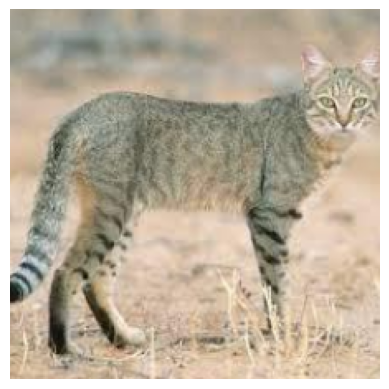

In [11]:
img_tensor = processed_images[9]

img = img_tensor.permute(1, 2, 0)
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

img = img * std + mean
img = img.clamp(0, 1)

plt.imshow(img.numpy())
plt.axis('off')
plt.show()

### Problem 5. Load the images efficiently (1 point)
Now that you've seen how to prepare the images for passing to the model... find a way to do it efficiently. Instead of loading the entire dataset in the RAM, read the images in batches (e.g. 4 images at a time). The goal is to read these, preprocess them, maybe save the preprocessed results in RAM.

If you've already done this in one of the previous problems, just skip this one. You'll get your point for it.

\* Even better, save the preprocessed image arrays (they will not be valid .jpg file) as separate files, so you can load them "lazily" in the following steps. This is a very common optimization to work with large datasets.

In [12]:
input_folder = "data/unique_african_wildcat"
preprocessed_tensors_folder = "data/preprocessed_tensors"
os.makedirs(preprocessed_tensors_folder, exist_ok=True)

weights = ResNet50_Weights.DEFAULT
transform = weights.transforms()

image_filenames = [f for f in os.listdir(input_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

batch_size = 4

for i in range(0, len(image_filenames), batch_size):
    batch_files = image_filenames[i:i + batch_size]

    for filename in batch_files:    
        try:
            image_path = os.path.join(input_folder, filename)
            img = Image.open(image_path).convert("RGB")

            tensor = transform(img)

            tensor_path = os.path.join(preprocessed_tensors_folder, filename.replace(".jpg", ".pt").replace(".jpeg", ".pt").replace(".png", ".pt"))
            torch.save(tensor, tensor_path)

        except Exception as e:
            print(f"Error {filename}: {e}")
len(os.listdir(preprocessed_tensors_folder))

54

### Problem 6. Predictions (1 point)
Finally, you're ready to get into the meat of the problem. Obtain predictions from your model and evaluate them. This will likely involve manual work to decide how the returned classes relate to the original ones.

Create a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) to evaluate the classification.

In [13]:
weights = ResNet50_Weights.DEFAULT
model = models.resnet50(weights=weights)
model.eval()

path_unique_african_wildcat = "data/unique_african_wildcat"
image_files = [f for f in os.listdir(path_unique_african_wildcat) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

for filename in image_files:
    image_path = os.path.join(path_unique_african_wildcat, filename)
    img = Image.open(image_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0)

    with torch.no_grad():
        output = model(input_tensor)

    predicted_idx = torch.argmax(output[0]).item()
    class_name = weights.meta["categories"][predicted_idx]

    print(f"{filename} → {class_name}")

af_01.jpg → Egyptian cat
af_02.jpg → Egyptian cat
af_03.jpg → lynx
af_04.jpg → Egyptian cat
af_05.jpg → lynx
af_06.jpg → Egyptian cat
af_07.jpg → Egyptian cat
af_08.jpg → Egyptian cat
af_09.jpg → Egyptian cat
af_10.jpg → Egyptian cat
af_11.jpg → Egyptian cat
af_12.jpg → Egyptian cat
af_13.jpg → lynx
af_14.jpg → lynx
af_15.jpg → Egyptian cat
af_16.jpg → tabby
af_17.jpg → Egyptian cat
af_18.jpg → grey fox
af_19.jpg → Egyptian cat
af_20.jpg → Egyptian cat
af_21.jpg → Egyptian cat
af_22.jpg → tabby
af_23.jpg → grey fox
af_24.jpg → Egyptian cat
af_25.jpg → Egyptian cat
af_26.jpg → Egyptian cat
af_27.jpg → lynx
af_28.jpg → Egyptian cat
af_29.jpg → Egyptian cat
af_30.jpg → Egyptian cat
af_31.jpg → lynx
af_32.jpg → Egyptian cat
af_33.jpg → Egyptian cat
af_34.jpg → Egyptian cat
af_35.jpg → Egyptian cat
af_36.jpg → Egyptian cat
af_37.jpg → Egyptian cat
af_38.jpg → lynx
af_39.jpg → tabby
af_40.jpg → lynx
af_41.jpg → Egyptian cat
af_42.jpg → Egyptian cat
af_43.jpg → tabby
af_44.jpg → Egyptian cat


### Problem 7. Grayscale (1 point)
Converting the images to grayscale should affect the classification negatively, as we lose some of the color information.

Find a way to preprocess the images to grayscale (using what you already have in Problem 4 and 5), pass them to the model, and compare the classification results to the previous ones.

In [14]:

os.makedirs(preprocessed_tensors_folder, exist_ok=True)

weights = ResNet50_Weights.DEFAULT
transform = weights.transforms()

image_filenames = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

for filename in image_filenames:
    image_path = os.path.join(folder_path, filename)
    try:
        img = Image.open(image_path).convert("L")
        img = img.convert("RGB")
        tensor = transform(img)

        tensor_path = os.path.join(preprocessed_tensors_folder, filename.replace(".jpg", ".pt").replace(".jpeg", ".pt").replace(".png", ".pt"))
        torch.save(tensor, tensor_path)

    except Exception as e:
        print(f"Error {filename}: {e}")

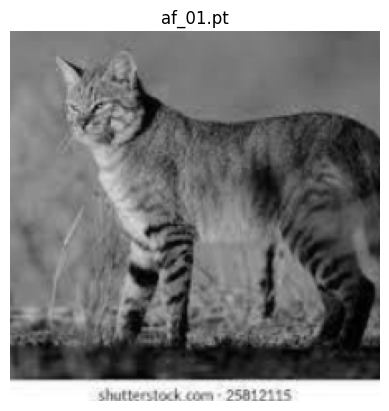

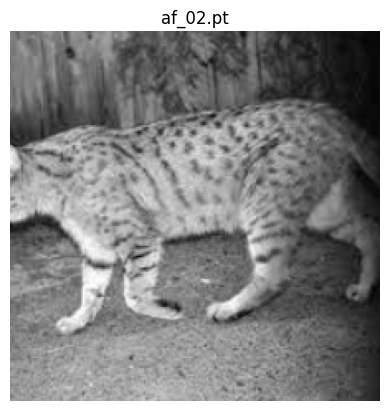

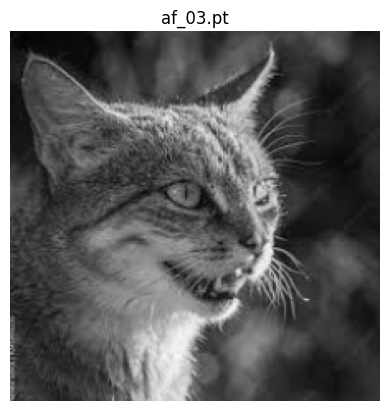

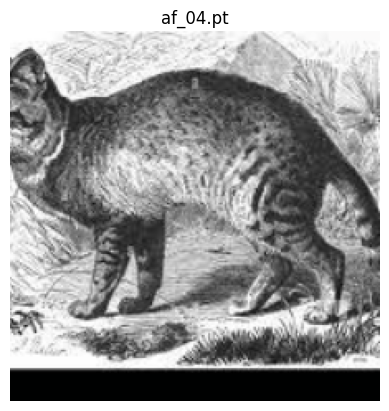

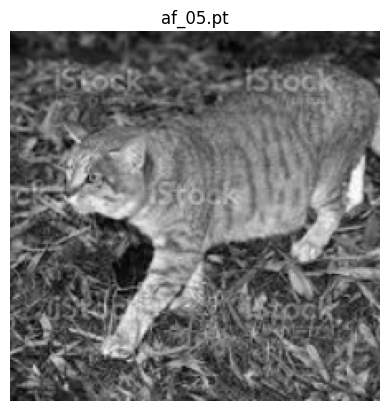

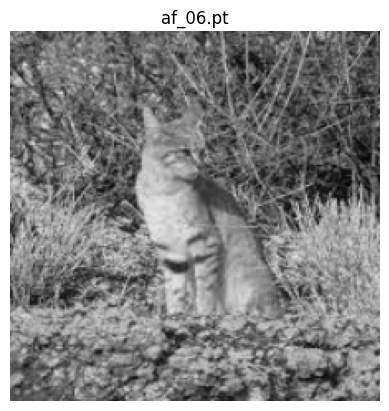

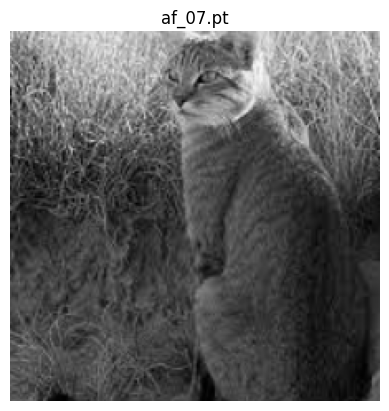

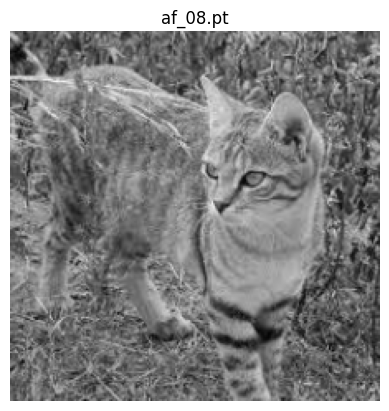

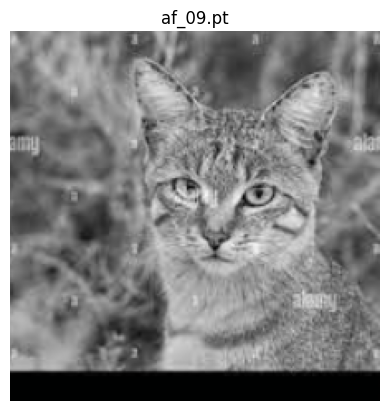

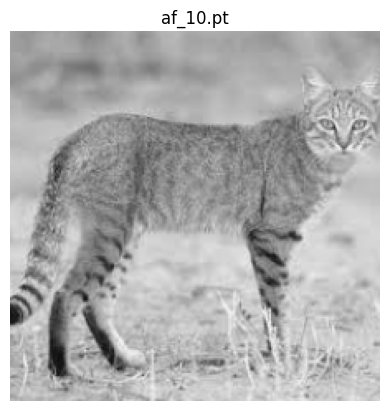

In [15]:
def extract_number(filename):
    match = re.search(r'af_(\d+)', filename)
    return int(match.group(1)) if match else -1

tensor_files = sorted(os.listdir(preprocessed_tensors_folder), key=extract_number)[:10]

unnormalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

for fname in tensor_files:
    tensor = torch.load(os.path.join(preprocessed_tensors_folder, fname))
    img = unnormalize(tensor).clamp(0, 1).permute(1, 2, 0)
    plt.imshow(img, cmap='gray')
    plt.title(fname)
    plt.axis("off")
    plt.show()

### Problem 8. Deep image features (1 point)
Find a way to extract one-dimensional vectors (features) for each (non-grayscale) image, using your model. This is typically done by "short-circuiting" the model output to be an intermediate layer, while keeping the input the same. 

In case the outputs (also called feature maps) have different shapes, you can flatten them in different ways. Try to not create huge vectors; the goal is to have a relatively short sequence of numbers which describes each image.

You may find a tutorial like [this](https://towardsdatascience.com/exploring-feature-extraction-with-cnns-345125cefc9a) pretty useful but note your implementation will depend on what model (and framework) you've decided to use.

It's a good idea to save these as one or more files, so you'll spare yourself a ton of preprocessing.

In [16]:
feature_folder = "data/features"
os.makedirs(feature_folder, exist_ok=True)


weights = ResNet50_Weights.DEFAULT
# model = resnet50(weights=weights)
model = models.resnet50(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])
model.eval()


transform = weights.transforms()


for filename in sorted(os.listdir(path_unique_african_wildcat)):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        image_path = os.path.join(path_unique_african_wildcat, filename)

        img = Image.open(image_path).convert("RGB")
        tensor = transform(img).unsqueeze(0) 

        with torch.no_grad():
            features = model(tensor)
            features = features.squeeze().flatten()

        
        feature_path = os.path.join(feature_folder, filename.replace(".jpg", ".pt").replace(".jpeg", ".pt").replace(".png", ".pt"))
        torch.save(features, feature_path)
len(os.listdir(feature_folder))

c:\Users\vando\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\vando\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


54

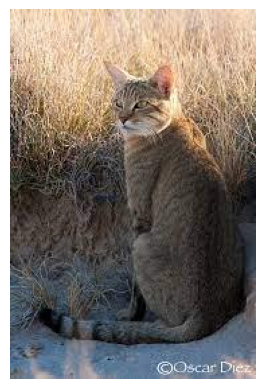

In [17]:
example_image = "data/unique_african_wildcat/af_07.jpg"
example_feature = "data/features/af_07.pt"

img = Image.open(example_image).convert("RGB")

features = torch.load(example_feature)
plt.imshow(img)
plt.axis("off")
plt.show()

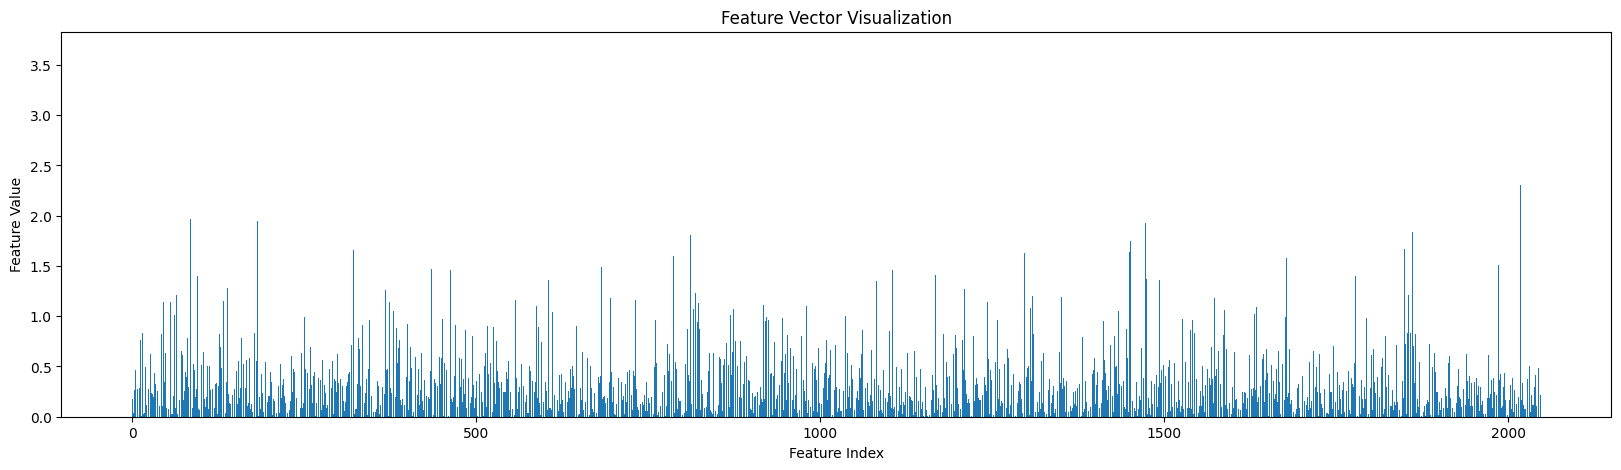

In [18]:
example_feature = "data/features/af_07.pt"

features = torch.load(example_feature)

plt.figure(figsize=(20, 5))
plt.bar(range(len(features)), features.numpy())
plt.title("Feature Vector Visualization")
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.show()

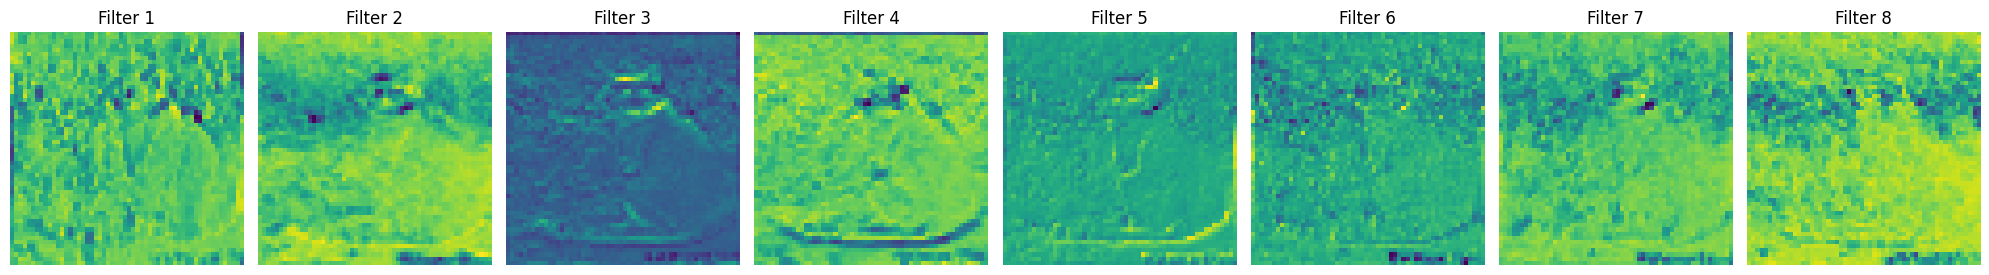

In [19]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.eval()


img_path = "data/unique_african_wildcat/af_07.jpg"
img = Image.open(img_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

input_tensor = transform(img).unsqueeze(0)

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


model.layer1[0].conv1.register_forward_hook(get_activation('conv1'))


with torch.no_grad():
    output = model(input_tensor)


feature_maps = activation['conv1'].squeeze()
num_feature_maps = feature_maps.shape[0]


fig, axes = plt.subplots(1, 8, figsize=(20, 5))
for idx in range(8):
    fmap = feature_maps[idx].cpu().numpy()
    axes[idx].imshow(fmap, cmap='viridis')  
    axes[idx].axis('off')
    axes[idx].set_title(f'Filter {idx+1}')
plt.tight_layout()
plt.show()

##### Here we load ResNet50 and add a "hook" that intercepts the output of one of the inner layers. We pass the image through the model, but instead of using the final classification, we extract the intermediate feature maps. We visualize these feature maps as images, applying a color map (viridis) to highlight the active areas. This way we can see how the model "perceives" different parts of the image in the deep layers.

### Problem 9. Putting deep image features to use (1 points)
Try to find similar images, using a similarity metric on the features you got in the previous problem. Two good metrics are `mean squared error` and `cosine similarity`. How do they work? Can you spot images that look too similar? Can you explain why?

\* If we were to take Fourier features (in a similar manner, these should be a vector of about the same length), how do they compare to the deep features; i.e., which features are better to "catch" similar images?

Highest Cosine Similarity: 0.9429


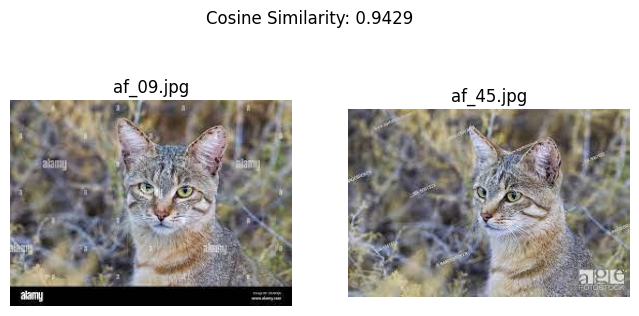

Lowest MSE: 0.029428


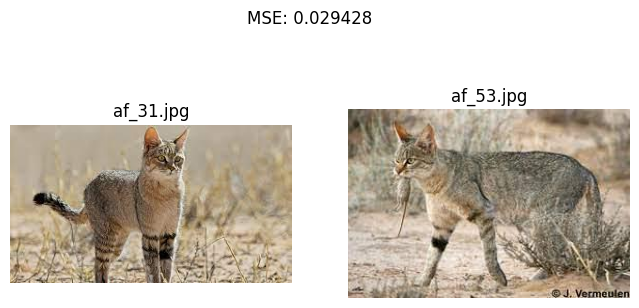

In [20]:
feature_folder = "data/features"
image_folder = "data/unique_african_wildcat"

features = []
filenames = []

for filename in sorted(os.listdir(feature_folder)):
    if filename.endswith(".pt"):
        feature_path = os.path.join(feature_folder, filename)
        feat = torch.load(feature_path).numpy()
        features.append(feat)
        filenames.append(filename.replace(".pt", ".jpg"))

features = np.array(features)

cos_sim_matrix = cosine_similarity(features)

mse_matrix = np.zeros((len(features), len(features)))

for i in range(len(features)):
    for j in range(len(features)):
        mse_matrix[i, j] = np.mean((features[i] - features[j]) ** 2)

def show_image_pair(idx1, idx2, title):
    img1 = Image.open(os.path.join(image_folder, filenames[idx1]))
    img2 = Image.open(os.path.join(image_folder, filenames[idx2]))
    
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img1)
    plt.title(filenames[idx1])
    plt.axis("off")
    
    plt.subplot(1,2,2)
    plt.imshow(img2)
    plt.title(filenames[idx2])
    plt.axis("off")
    
    plt.suptitle(title)
    plt.show()

np.fill_diagonal(cos_sim_matrix, -1)
idx1, idx2 = np.unravel_index(np.argmax(cos_sim_matrix), cos_sim_matrix.shape)
print(f"Highest Cosine Similarity: {cos_sim_matrix[idx1, idx2]:.4f}")
show_image_pair(idx1, idx2, f"Cosine Similarity: {cos_sim_matrix[idx1, idx2]:.4f}")

np.fill_diagonal(mse_matrix, np.inf)
idx1, idx2 = np.unravel_index(np.argmin(mse_matrix), mse_matrix.shape)
print(f"Lowest MSE: {mse_matrix[idx1, idx2]:.6f}")
show_image_pair(idx1, idx2, f"MSE: {mse_matrix[idx1, idx2]:.6f}")

### * Problem 10. Explore, predict, and evaluate further
You can do a ton of things here, at your desire. For example, how does masking different areas of the image affect classification - a method known as **saliency map** ([info](https://en.wikipedia.org/wiki/Saliency_map))? Can we detect objects? Can we significantly reduce the number of features (keeping the quality) that we get? Can we reliably train a model to predict our own classes? We'll look into these in detail in the future.